In [1]:

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np


In [2]:
h1=1
w1=1

def force(x):
    return -h1*4*(x**2-w1)*x;
def energy(x):
    return h1*(x**2-w1)**2

nrSteps = 10000

x = np.ones(nrSteps)
p = np.random.randn(nrSteps)
dt=0.01
gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))


pn = p[0]
xn = x[0]
    
f=force(xn)

for n in range(nrSteps-1):
        
        if n % 10 ==0:
            pn = p[0]
            xn = x[0]
        
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f=force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        p[n+1] = pn
        x[n+1] = xn
    


In [3]:
# take a gaussian as initial conditions.
x = np.random.randn(nrSteps) * 0.1 + 0.2

q_density = 1.0/np.sqrt(2*np.pi*0.1**2) * np.exp(-(x-.2)**2 / (2*0.1**2))

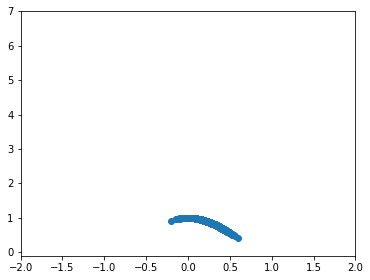

In [4]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x, energy(x))
    ax.set_xlim([-2,2])
    ax.set_ylim([-0.1,7])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None)

#  Stein force

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def compute_stein_force(XL, leader_set):
   
    my_force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    force_resh = np.asarray(my_force)
    # create numpy array from the list XL which has also units
    
    # choose leader particles using the index set leader_set
    X_leader = XL[leader_set]
   
    # kernel scaling parameter
    h=0.1
    
    distances = cdist(XL[:,np.newaxis], X_leader[:,np.newaxis])
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel, force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # add force unit and divide by kT
    #f_MDforce = f_MDforce * model.force_unit / smpl.kT
    f_MDforce = f_MDforce  / kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel, X_leader)
    f_der += 2.0/h * np.sum(kernel,1) * XL
    f_der = f_der / len(leader_set)
    # add unit
    #f_der = f_der * model.x_unit**(-1)
    
    grad_force = (-2.0/h*XL*np.dot(kernel, force_resh) +2.0/h * np.dot(kernel, X_leader*force_resh)) / kT
    grad_force += 2.0/h*np.sum(kernel,1)
    grad_force -= 4.0/(h**2) * (XL**2 * np.sum(kernel,1) -2.0*XL * np.dot(kernel, X_leader) + np.dot(kernel, X_leader**2))
    grad_force = grad_force / len(leader_set)
    
    return f_MDforce + f_der, grad_force

#def update_weights(XL, leader_set, q_dens):
    





# Iterate Stein

In [22]:
print(numberOfLeaderParticles)

9000


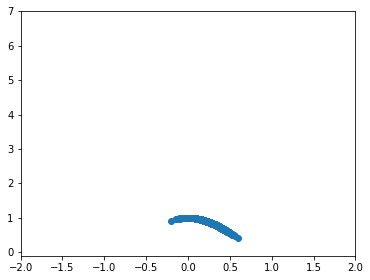

Stein iteration 0


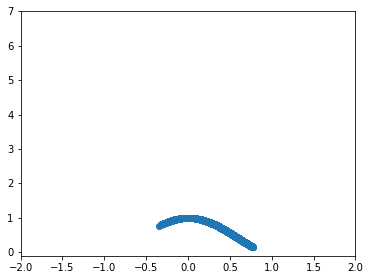

Stein iteration 50


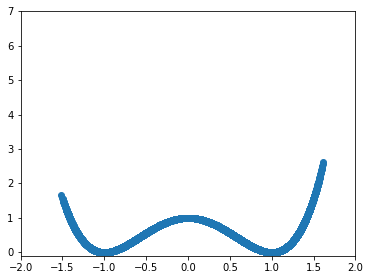

Stein iteration 100


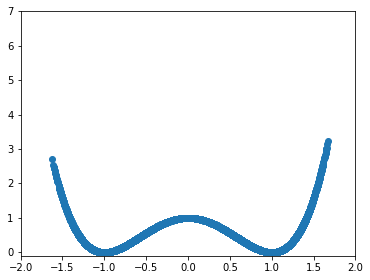

Stein iteration 150


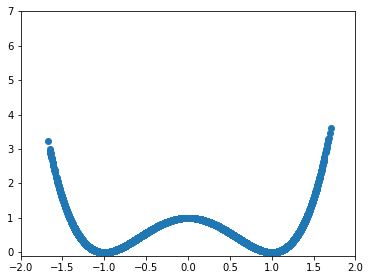

Stein iteration 200


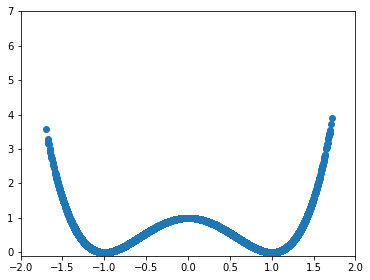

Stein iteration 250


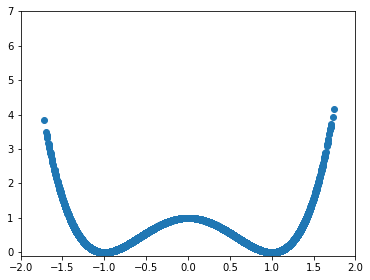

Stein iteration 300


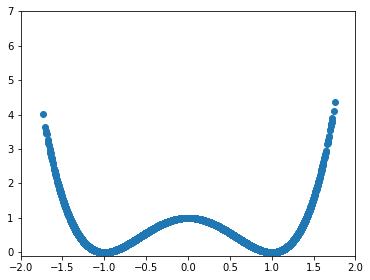

Stein iteration 350


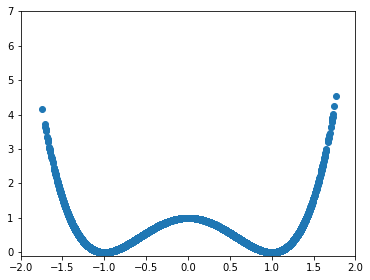

Stein iteration 400


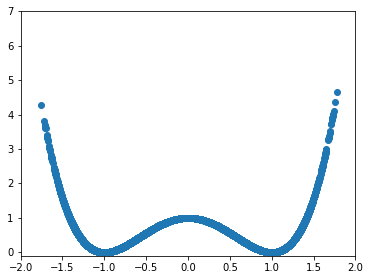

Stein iteration 450


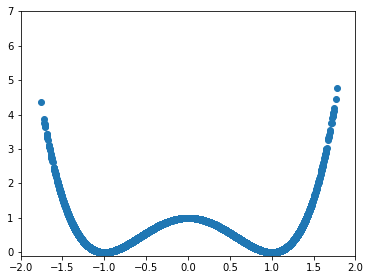

Stein iteration 500


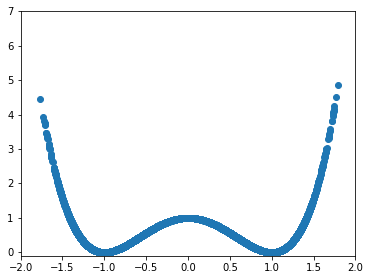

Stein iteration 550


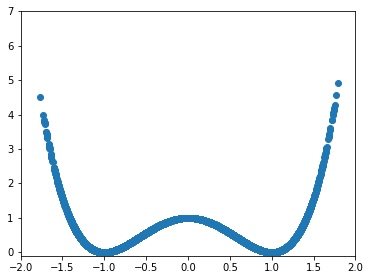

Stein iteration 600


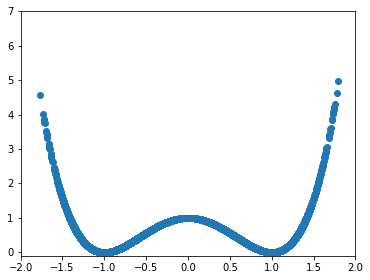

Stein iteration 650


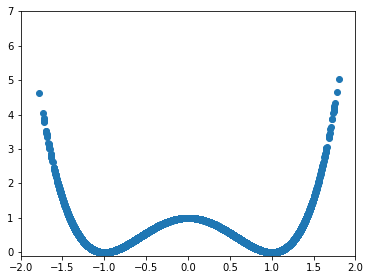

Stein iteration 700


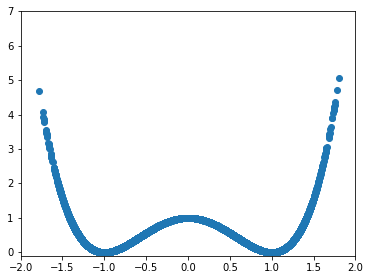

Stein iteration 750


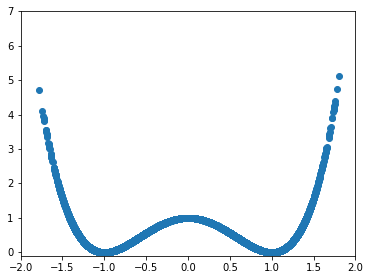

Stein iteration 800


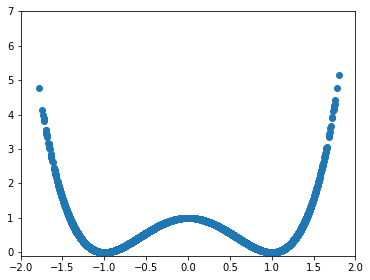

Stein iteration 850


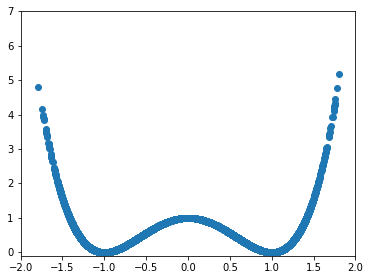

Stein iteration 900


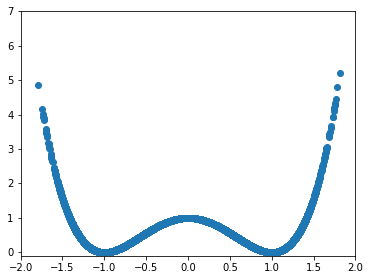

Stein iteration 950


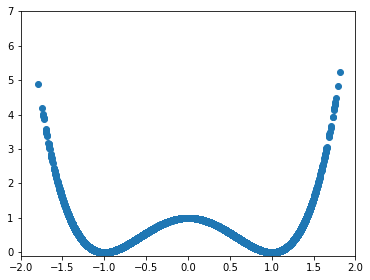

In [6]:
numberOfSteinSteps = 1000#50000

X_short = np.copy(x)

epsilon_step=0.1

# choose leader set
numberOfLeaderParticles = int(0.9*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f, grad_force = compute_stein_force(XL,leader_set)
    XL = (XL + epsilon_step * f)#/mass );
    q =  np.copy(XL)
    q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    weights = np.exp(-energy(q)) / q_density
    KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    Obs_average[ns] = np.mean(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

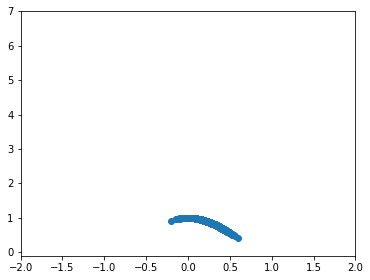

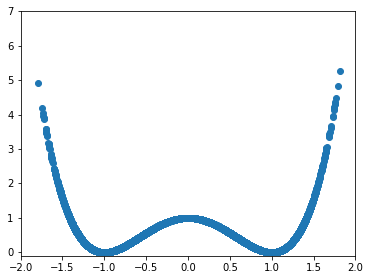

In [7]:
plotSampling_fromData(x,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')


In [8]:
# from scipy.integrate import quadrature
# def fit_distribution(x):
#     x = x[:,0,0]
#     Z = 0.5725340617#quadrature(lambda y : np.exp(-energy(y)), -1000, 1000)[1]
#     xx = np.linspace(-2,2,100)
    
#     fig = plt.figure(figsize=(6,4.5))
#     ax = fig.add_subplot(111)
#     ax.hist(x, 50, density=True);
#     ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
   
#     plt.show()

In [9]:
# fit_distribution(q)


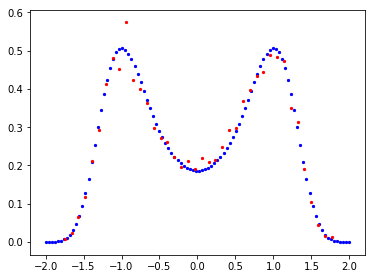

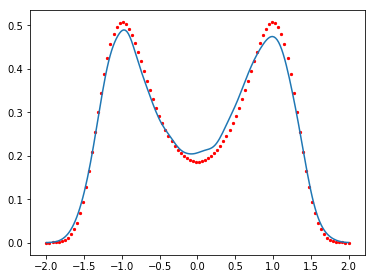

In [10]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xx = np.linspace(-2,2,100)
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
ax.scatter(xx, np.exp(- energy(xx))/Z , c='b', s=5)
ax.scatter(bin_centers, data , c='r', s=5)
plt.show()

from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()

In [15]:
Z = 1.973732150#0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X_short))
print(np.mean(q))
print('************')

print('E[V(x)] = .4172545129')#0.5247724179')
print(np.mean(energy(X_short)))
print(np.mean(energy(q)))
print('************')

print('E[-f(x)*x] = 1')
print(np.mean((-force(X_short)* X_short)))
print((np.mean(-force(q)* q)))

Z=1.97373215
E[x] = 0
0.201089539163
0.00700410133049
************
E[V(x)] = .4172545129
0.903712647097
0.422601803055
************
E[-f(x)*x] = 1
-0.183898148194
0.967344089582


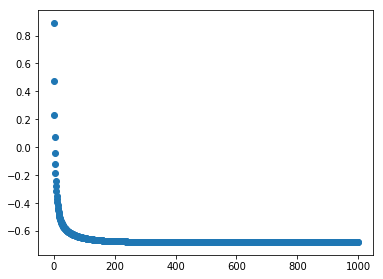

In [16]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), -KL)
#ax.set_ylim(1e-4, 1)
plt.show()

In [17]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/stein'
# fps = 1000
# file_list = glob.glob('SteinFigures/'+'/*.png') # Get all the pngs in the current directory
# list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

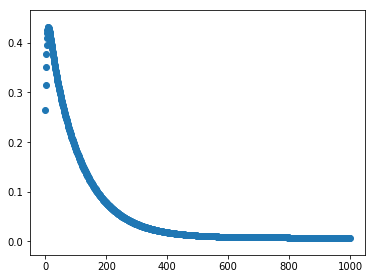

In [18]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), Obs_average)
#ax.set_ylim(1e-4, 1)
plt.show()